<a href="https://colab.research.google.com/github/jproney/AF2Rank/blob/master/figures/S7_ParDE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%bash
git clone https://github.com/jproney/AF2Rank.git

Cloning into 'AF2Rank'...


In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def plot_me(scores, x="tm_i", y="composite", 
            title=None, diag=False, scale_axis=True, dpi=100,
            mk_fig=True, zscore=False, add_labels=True, **kwargs):
  def rescale(a,amin=None,amax=None):  
    a = np.copy(a)
    if amin is None: amin = a.min()
    if amax is None: amax = a.max()
    a[a < amin] = amin
    a[a > amax] = amax
    return (a - amin)/(amax - amin)

  if mk_fig:
    plt.figure(figsize=(5,5), dpi=dpi)
  if title is not None: plt.title(title)
  x_vals = np.array([k[x] for k in scores])
  y_vals = np.array([k[y] for k in scores])

  if zscore:
    y_mean = y_vals.mean(0)
    y_std = y_vals.std(0)
    y_vals = (y_vals - y_mean) / y_std
  
  c = rescale(np.array([k["plddt"] for k in scores]),0.5,0.9)
  plt.scatter(x_vals, y_vals, c=c*0.75, s=5, vmin=0, vmax=1, cmap="gist_rainbow",
              rasterized=True, **kwargs)
  if diag:
    plt.plot([0,1],[0,1],color="black")
  
  if add_labels:
    labels = {"tm_i":"TMscore of Input",
              "tm_o":"TMscore of Output",
              "tm_io":"TMscore between Input and Output",
              "ptm":"Predicted TMscore (pTM)",
              "i_ptm":"Predicted interface TMscore (ipTM)",
              "plddt":"Predicted LDDT (pLDDT)",
              "composite":"Composite"}
    plt.xlabel(labels.get(x,x));  plt.ylabel(labels.get(y,y))
  if scale_axis:
    if x in labels: plt.xlim(-0.1, 1.1)
    if y in labels: plt.ylim(-0.1, 1.1)
  
  if zscore:
    return y_mean, y_std

def get_sorted_scores(x, metric="composite", high_better=True, cutoff=0.1, top=500):
  if metric == "dgram_cce": higher_better = False
  scores = np.array([[k[metric],k["fitness"]] for k in x])
  scores = scores[scores[:,0].argsort()]
  if high_better:
    scores = scores[::-1]
  return np.cumsum(scores[:top,1] > cutoff)/np.arange(1,top+1)

def get_spearman(x, metric="composite"):
  scores = np.array([[k[metric],k["fitness"]] for k in x])
  return spearmanr(scores[:,0], scores[:,1]).correlation

In [40]:
PATH = "/content/AF2Rank/figures/data/ParDE"
labels = ["average"] + [f"ptm_{k}" for k in range(1,3)] + [f"mult_{k}" for k in range(1,6)] + [f"mult_{k}_nomask" for k in range(1,6)]

M = "composite"
X = [np.load(f"{PATH}/r1_ptm{k}_default.npy", allow_pickle=True) for k in [1,1,2]]
X += [np.load(f"{PATH}/r1_mult{k}.npy", allow_pickle=True) for k in [1,2,3,4,5]]
X += [np.load(f"{PATH}/r1_mult{k}_nomask.npy", allow_pickle=True) for k in [1,2,3,4,5]]
true_data = []
pred_data = []
lddt_data = []
for n in range(len(X[0])):
  true_data.append(X[0][n]["fitness"])
  pred_data.append([x[n][M] for x in X])
  lddt_data.append([x[n]["plddt"] for x in X])
true_data = np.array(true_data)
pred_data = np.array(pred_data)
lddt_data = np.array(lddt_data).mean(-1)
pred_data = ((pred_data - pred_data.mean(0))/pred_data.std(0))

In [44]:
x = X[0]
for i in range(1,len(X)):
  for n in range(len(x)):
    x[n][M] = pred_data[n][i]
    x[n]["plddt"] = lddt_data[n]
  r_single = get_spearman(x, metric=M).mean()

  y_true = np.array([a["fitness"] > 0.1 for a in x],float)
  y_score = np.array([a["composite"] for a in x],float)
  roc_auc_single = roc_auc_score(y_true, y_score)
  sauc_single = get_sorted_scores(x).mean()

  for n in range(len(x)):
    x[n][M] = pred_data[n][1:(i+1)].mean(-1)
    x[n]["plddt"] = lddt_data[n]
  r_average = get_spearman(x, metric=M).mean()

  y_true = np.array([a["fitness"] > 0.1 for a in x],float)
  y_score = np.array([a["composite"] for a in x],float)
  roc_auc_average = roc_auc_score(y_true, y_score)
  sauc_average = get_sorted_scores(x).mean()

  print(f"{labels[i]}\t{sauc_single:.3f}\t{sauc_average:.3f}\t{r_single:.3f}\t{r_average:.3f}\t{roc_auc_single:.3f}\t{roc_auc_average:.3f}")

ptm_1	0.718	0.718	0.374	0.374	0.888	0.888
ptm_2	0.291	0.469	0.318	0.360	0.833	0.875
mult_1	0.846	0.721	0.383	0.380	0.912	0.897
mult_2	0.791	0.794	0.355	0.394	0.944	0.928
mult_3	0.813	0.821	0.396	0.404	0.942	0.938
mult_4	0.798	0.827	0.286	0.393	0.895	0.940
mult_5	0.828	0.841	0.375	0.394	0.921	0.940
mult_1_nomask	0.750	0.857	0.385	0.401	0.918	0.942
mult_2_nomask	0.863	0.864	0.367	0.401	0.915	0.941
mult_3_nomask	0.847	0.876	0.368	0.402	0.928	0.942
mult_4_nomask	0.804	0.881	0.423	0.410	0.942	0.945
mult_5_nomask	0.868	0.888	0.378	0.410	0.933	0.946


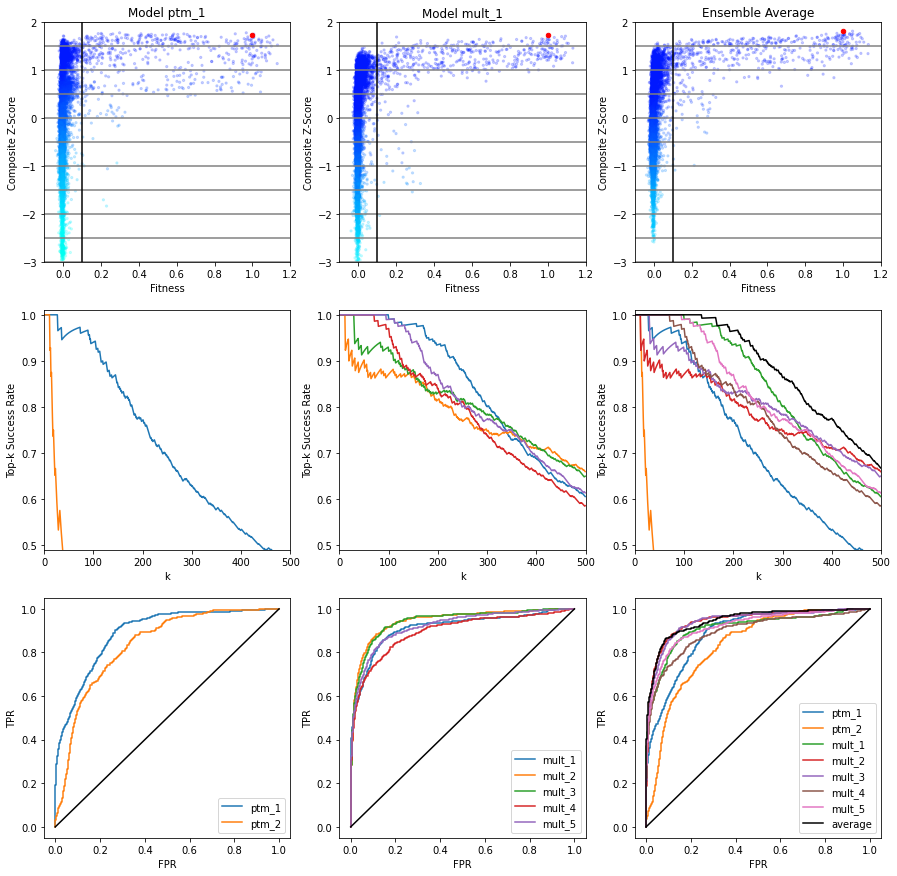

In [47]:
plt.figure(figsize=(15,15))
plt.subplot(3,3,1)
n = 1; plt.title(f"Model {labels[n]}")
y_mu,y_sg = plot_me(X[n], x="fitness", y=M, scale_axis=False, mk_fig=False, alpha=0.2, zscore=True,add_labels=False)
LABELS = [k["id"] for k in X[n]]
for k in np.linspace(-3,2,11): plt.plot([-0.2,1.2],[k,k],color="grey")
plt.scatter([X[n][LABELS.index("LWDK")]["fitness"]],
            ([X[n][LABELS.index("LWDK")][M]]-y_mu)/y_sg,color="red",s=20,label="wildtype")
plt.ylim(-3,2);plt.xlim(-0.1,1.2)
plt.plot([0.1,0.1],[-3,2],color="black")
plt.xlabel("Fitness"); plt.ylabel("Composite Z-Score")

plt.subplot(3,3,2)
n = 3; plt.title(f"Model {labels[n]}")
y_mu,y_sg = plot_me(X[n], x="fitness", y=M, scale_axis=False, mk_fig=False, alpha=0.2, zscore=True, add_labels=False)
LABELS = [k["id"] for k in X[n]]
for k in np.linspace(-3,2,11): plt.plot([-0.2,1.2],[k,k],color="grey")
plt.scatter([X[n][LABELS.index("LWDK")]["fitness"]],
            ([X[n][LABELS.index("LWDK")][M]]-y_mu)/y_sg,color="red",s=20,label="wildtype")
plt.ylim(-3,2);plt.xlim(-0.1,1.2)
plt.plot([0.1,0.1],[-3,2],color="black")
plt.xlabel("Fitness"); plt.ylabel("Composite Z-Score")

plt.subplot(3,3,3)
n = 0; plt.title(f"Ensemble Average")
plot_me(X[n], x="fitness", y=M, scale_axis=False, mk_fig=False, alpha=0.2, zscore=False, add_labels=False)
LABELS = [k["id"] for k in X[n]]
for k in np.linspace(-3,2,11): plt.plot([-0.2,1.2],[k,k],color="grey")
plt.scatter([X[n][LABELS.index("LWDK")]["fitness"]],
            [X[n][LABELS.index("LWDK")][M]],color="red",s=20,label="wildtype")
plt.ylim(-3,2);plt.xlim(-0.1,1.2)
plt.plot([0.1,0.1],[-3,2],color="black")
plt.xlabel("Fitness"); plt.ylabel("Composite Z-Score")

plt.subplot(3,3,4)
for n,(x,y) in enumerate(zip(X[1:3],labels[1:3])):
  plt.plot(get_sorted_scores(x, metric=M),label=y)
plt.xlabel("k"); plt.ylabel("Top-k Success Rate")
plt.ylim(0.49,1.01);plt.xlim(0,500)

plt.subplot(3,3,5)
for n,(x,y) in enumerate(zip(X[3:8],labels[3:8])):
  plt.plot(get_sorted_scores(x, metric=M),label=y)
plt.xlabel("k"); plt.ylabel("Top-k Success Rate")
plt.ylim(0.49,1.01);plt.xlim(0,500)

plt.subplot(3,3,6)
for n,(x,y) in enumerate(zip(np.roll(X[:8],-1,0),np.roll(labels[:8],-1))):
  plt.plot(get_sorted_scores(x, metric=M),label=y, color="black" if n == 7 else None)
plt.xlabel("k"); plt.ylabel("Top-k Success Rate")
plt.ylim(0.49,1.01);plt.xlim(0,500)

plt.subplot(3,3,7)
for n,(x,y) in enumerate(zip(X[1:3],labels[1:3])):
  y_true = np.array([a["fitness"] > 0.1 for a in x],float)
  y_score = np.array([a["composite"] for a in x],float)
  fpr, tpr, thres = roc_curve(y_true, y_score)
  plt.plot(fpr,tpr, label=y)
plt.plot([0,1],[0,1], color="black")
plt.xlabel("FPR");plt.ylabel("TPR")
plt.legend()

plt.subplot(3,3,8)
for n,(x,y) in enumerate(zip(X[3:8],labels[3:8])):
  y_true = np.array([a["fitness"] > 0.1 for a in x],float)
  y_score = np.array([a["composite"] for a in x],float)
  fpr, tpr, thres = roc_curve(y_true, y_score)
  plt.plot(fpr,tpr, label=y)
plt.plot([0,1],[0,1], color="black")
plt.xlabel("FPR");plt.ylabel("TPR")
plt.legend()

plt.subplot(3,3,9)
for n,(x,y) in enumerate(zip(np.roll(X[:8],-1,0),np.roll(labels[:8],-1))):
  y_true = np.array([a["fitness"] > 0.1 for a in x],float)
  y_score = np.array([a["composite"] for a in x],float)
  fpr, tpr, thres = roc_curve(y_true, y_score)
  plt.plot(fpr,tpr, label=y, color="black" if n == 7 else None)
plt.plot([0,1],[0,1], color="black")
plt.xlabel("FPR");plt.ylabel("TPR")
plt.legend()


plt.savefig(f"ParDE.pdf", bbox_inches='tight', pad_inches=0, dpi=200)
plt.show()